# Batch inference

<div align="left">
<a target="_blank" href="https://console.anyscale.com/"><img src="https://raw.githubusercontent.com/ray-project/ray/c34b74c22a9390aa89baf80815ede59397786d2e/doc/source/_static/img/run-on-anyscale.svg"></a>&nbsp;

<a href="https://github.com/anyscale/multimodal-ai" role="button"><img src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
</div>

This tutorial executes a batch inference workload that connects the following heterogeneous workloads:
- distributed read from cloud storage (CPU)
- apply distributed preprocessing (CPU)
- batch inference (GPU)
- distributed write to cloud storage (CPU)

<img src="https://raw.githubusercontent.com/anyscale/multimodal-ai/refs/heads/main/images/batch_inference.png" width=1000>

In [ ]:
%%bash
pip install -q -r /home/ray/default/requirements.txt
pip install -q -e /home/ray/default/doggos


Successfully registered `ipywidgets, matplotlib` and 4 other packages to be installed on all cluster nodes.
View and update dependencies here: https://console.anyscale.com/cld_kvedZWag2qA8i5BjxUevf5i7/prj_cz951f43jjdybtzkx1s5sjgz99/workspaces/expwrk_1dp3fa7w5hu3i83ldsi7lqvp9t?workspace-tab=dependencies
Successfully registered `doggos` package to be installed on all cluster nodes.
View and update dependencies here: https://console.anyscale.com/cld_kvedZWag2qA8i5BjxUevf5i7/prj_cz951f43jjdybtzkx1s5sjgz99/workspaces/expwrk_1dp3fa7w5hu3i83ldsi7lqvp9t?workspace-tab=dependencies


**Note**: A kernel restart may be required for all dependencies to become available. 

If using **uv**, then:
1. Turn off the runtime dependencies (`Dependencies` tab up top > Toggle off `Pip packages`). And no need to run the `pip install` commands above.
2. Change the python kernel of this notebook to use the `venv` (Click on `base (Python x.yy.zz)` on top right cordern of notebook > `Select another Kernel` > `Python Environments...` > `Create Python Environment` > `Venv` > `Use Existing`) and done! Now all the notebook's cells will use the virtual env.
3. Change the py executable to use `uv run` instead of `python` by adding this line after importing ray.
```python
import os
os.environ.pop("RAY_RUNTIME_ENV_HOOK", None)
import ray
ray.init(runtime_env={"py_executable": "uv run", "working_dir": "/home/ray/default"})
```

In [ ]:
%load_ext autoreload
%autoreload all


In [ ]:
import os
import ray
import sys
sys.path.append(os.path.abspath("../doggos/"))


In [ ]:
# If using UV
# os.environ.pop("RAY_RUNTIME_ENV_HOOK", None)
# ray.init(runtime_env={"py_executable": "uv run", "working_dir": "/home/ray/default"})


In [ ]:
from doggos import utils


## Data ingestion

Start by reading the data from a public cloud storage bucket.

In [ ]:
# Load data.
ds = ray.data.read_images(
    "s3://doggos-dataset/train", 
    include_paths=True, 
    shuffle="files",
)
ds.take(1)


2025-08-22 00:14:08,238	INFO worker.py:1747 -- Connecting to existing Ray cluster at address: 10.0.52.10:6379...
2025-08-22 00:14:08,250	INFO worker.py:1918 -- Connected to Ray cluster. View the dashboard at https://session-466hy7cqu1gzrp8zk8l4byz7l7.i.anyscaleuserdata.com 
2025-08-22 00:14:08,255	INFO packaging.py:588 -- Creating a file package for local module '/home/ray/default/doggos/doggos'.
2025-08-22 00:14:08,258	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_0193267f6c9951ce.zip' (0.02MiB) to Ray cluster...
2025-08-22 00:14:08,259	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_0193267f6c9951ce.zip'.
2025-08-22 00:14:08,262	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_6d26725922931a7a9e87fca928dfafe4f4e5e54b.zip' (1.18MiB) to Ray cluster...
2025-08-22 00:14:08,268	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_6d26725922931a7a9e87fca928dfafe4f4e5e54b.zip'.
2025-08-22 00:14:08,550	INFO dataset.p

Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- limit=1 3: 0.00 row [00:00, ? row/s]

2025-08-22 00:14:08,686	WARNING resource_manager.py:130 -- ⚠️  Ray's object store is configured to use only 28.2% of available memory (67.8GB out of 240.5GB total). For optimal Ray Data performance, we recommend setting the object store to at least 50% of available memory. You can do this by setting the 'object_store_memory' parameter when calling ray.init() or by setting the RAY_DEFAULT_OBJECT_STORE_MEMORY_PROPORTION environment variable.
2025-08-22 00:15:25,802	INFO streaming_executor.py:231 -- ✔️  Dataset dataset_59_0 execution finished in 77.16 seconds


[{'image': array([[[123, 118,  78],
          [125, 120,  80],
          [128, 120,  83],
          ...,
          [162, 128,  83],
          [162, 128,  83],
          [161, 127,  82]],
  
         [[123, 118,  78],
          [125, 120,  80],
          [127, 119,  82],
          ...,
          [162, 128,  83],
          [162, 128,  83],
          [161, 127,  82]],
  
         [[123, 118,  78],
          [125, 120,  80],
          [127, 119,  82],
          ...,
          [161, 128,  83],
          [161, 128,  83],
          [160, 127,  82]],
  
         ...,
  
         [[235, 234, 239],
          [233, 232, 237],
          [221, 220, 225],
          ...,
          [158,  95,  54],
          [150,  85,  53],
          [151,  88,  57]],
  
         [[219, 220, 222],
          [227, 228, 230],
          [222, 223, 225],
          ...,
          [153,  91,  54],
          [146,  83,  52],
          [149,  88,  59]],
  
         [[213, 217, 216],
          [217, 221, 220],
          [213,

<div class="alert alert-block alert"> <b> ✍️ Distributed READ/WRITE</b> 

Ray Data supports a wide range of data sources for both [loading](https://docs.ray.io/en/latest/data/loading-data.html) and [saving](https://docs.ray.io/en/latest/data/saving-data.html) from generic binary files in cloud storage to structured data formats used by modern data platforms. This example reads data from a public S3 bucket prepared with the dataset. This `read` operation, much like the `write` operation in a later step, runs in a distributed fashion. As a result, Ray Data processes the data in parallel across the cluster and doesn't need to load the data entirely into memory at once, making data loading scalable and memory-efficient.

<div class="alert alert-block alert"> <b>💡 Ray Data best practices</b>

- **trigger lazy execution**: use [`take`](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.take.html) to trigger the execution because Ray has lazy execution mode, which decreases execution time and memory utilization. But, this approach means that you need an operation like take, count, write, etc., to actually execute the workflow DAG.
- **shuffling strategies**: to shuffle the dataset because it's all ordered by class, randomly shuffle the ordering of input files before reading. Ray Data also provides an extensive list of [shuffling strategies](https://docs.ray.io/en/latest/data/shuffling-data.html) such as local shuffles, per-epoch shuffles, etc.
- **`materialize` during development**: use [`materialize`](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.materialize.html) to execute and materialize the dataset into Ray's [shared memory object store memory](https://docs.ray.io/en/latest/ray-core/objects.html). This way, you save a checkpoint at this point and future operations on the dataset can start from this point. You won't rerun all operations on the dataset again from scratch. This feature is convenient during development, especially in a stateful environment like Jupyter notebooks, because you can run from saved checkpoints.

    ```python
    ds = ds.map(...)
    ds = ds.materialize()
    ```

    **Note**: only use this during development and use it with small datasets, as it will load it all into memory.


You also want to add the class for each data point. When reading the data with `include_paths` Ray Data saves the filename with each data point. The filename has the class label in it so add that to each data point's row. Use Ray Data's [map](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map.html) function to apply the function to each row.

In [ ]:
def add_class(row):
    row["class"] = row["path"].rsplit("/", 3)[-2]
    return row


In [ ]:
# Add class.
ds = ds.map(add_class,
    num_cpus=1,
    num_gpus=0,
    concurrency=4)


<div class="alert alert-block alert"> <b> Ray Data streaming execution</b> 

❌ Traditional batch execution, for example, non-streaming like Spark without pipelining, SageMaker Batch Transform:
- Reads the entire dataset into memory or a persistent intermediate format.
- Only then starts applying transformations like .map, .filter, etc.
- Higher memory pressure and startup latency.

✅ Streaming execution with Ray Data:
- Starts processing chunks ("blocks") as they're loaded. No need to wait for entire dataset to load.
- Reduces memory footprint (no OOMs) and speeds up time to first output.
- Increase resource utilization by reducing idle time.
- Online-style inference pipelines with minimal latency.

<img src="https://raw.githubusercontent.com/anyscale/multimodal-ai/refs/heads/main/images/streaming.gif" width=1000>

**Note**: Ray Data isn't a real-time stream processing engine like Flink or Kafka Streams. Instead, it's batch processing with streaming execution, which is especially useful for iterative ML workloads, ETL pipelines, and preprocessing before training or inference. Ray typically has a [**2-17x throughput improvement**](https://www.anyscale.com/blog/offline-batch-inference-comparing-ray-apache-spark-and-sagemaker#-results-of-throughput-from-experiments) over solutions like Spark and SageMaker Batch Transform, etc.


## Batch embeddings




The previous section applied a mapping operation using a function to each row in the dataset. Now you're ready to generate embeddings from the data and using Ray Data's [`map_batches`](https://docs.ray.io/en/latest/data/api/doc/ray.data.Dataset.map_batches.html) to apply an operation across batches of the data. The operation is in the form of a callable, which is a function or a class with a `__call__` method.

In [ ]:
import numpy as np
from PIL import Image
import torch
from transformers import CLIPModel, CLIPProcessor


In [ ]:
class EmbedImages(object):
    def __init__(self, model_id, device):
        # Load CLIP model and processor
        self.processor = CLIPProcessor.from_pretrained(model_id)
        self.model = CLIPModel.from_pretrained(model_id)
        self.model.to(device)
        self.device = device

    def __call__(self, batch):
        # Load and preprocess images
        images = [Image.fromarray(np.uint8(img)).convert("RGB") for img in batch["image"]]
        inputs = self.processor(images=images, return_tensors="pt", padding=True).to(self.device)

        # Generate embeddings
        with torch.inference_mode():
            batch["embedding"] = self.model.get_image_features(**inputs).cpu().numpy()

        return batch


<div class="alert alert-block alert"> <b> Ray object store references</b> 

Instead of initializing the same model for each instance of the class above, we can instead use references to Ray's [shared memory object store](https://docs.ray.io/en/latest/ray-core/objects.html#objects-in-ray). We can load the model once, store it inside the default object store and then have each instance of our class refer to it.

```python
model = load_model(...)
model_ref = ray.put(model) 

class Foo:
    def __init__(self, model_ref):
        self.model = ray.get(model_ref)
        ...
```


In [ ]:
# Generate batch embeddings
embeddings_ds = ds.map_batches(
    EmbedImages,
    fn_constructor_kwargs={
        "model_id": "openai/clip-vit-base-patch32", 
        "device": "cuda",
    },  # class kwargs
    fn_kwargs={},  # __call__ kwargs
    concurrency=4,
    batch_size=64,
    num_gpus=1,
    accelerator_type="T4",
)
embeddings_ds = embeddings_ds.drop_columns(["image"])  # remove image column


## Ray Data

Ray Data not only makes it extremely easy to distribute workloads but also ensures that they with:
- **efficiency**: minimize CPU/GPU idle time with heterogeneous resource scheduling.
- **scalability**: streaming execution to petabyte-scale datasets, especially when [working with LLMs](https://docs.ray.io/en/latest/data/working-with-llms.html)
- **reliability** by checkpointing processes, especially when running workloads on spot instances with on-demand fallback.
- **flexibility**: connect to data from any source, apply transformations, and save to any format or location for your next workload.

<img src="https://raw.githubusercontent.com/anyscale/multimodal-ai/refs/heads/main/images/ray_data_solution.png" width=1000>

🔥 [RayTurbo Data](https://docs.anyscale.com/rayturbo/rayturbo-data) has more functionality on top of Ray Data:
- **accelerated metadata fetching** to improve reading from large datasets (start processes earlier).
- **optimized autoscaling** where actor pools are scaled up faster, start jobs before entire cluster is ready, etc.
- **high reliability** where entire fails jobs (even on spot instances), like head node, cluster, uncaptured exceptions, etc., can resume from checkpoints. OSS Ray can only recover from worker node failures.

## Data storage

In [ ]:
import shutil


In [ ]:
# Save to artifact storage.
embeddings_path = os.path.join("/mnt/cluster_storage", "doggos/embeddings")
if os.path.exists(embeddings_path): 
    shutil.rmtree(embeddings_path)  # clean up
embeddings_ds.write_parquet(embeddings_path)


2025-08-22 00:15:55,241	INFO logging.py:295 -- Registered dataset logger for dataset dataset_64_0
2025-08-22 00:15:55,265	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_64_0. Full logs are in /tmp/ray/session_2025-08-21_18-48-13_464408_2298/logs/ray-data
2025-08-22 00:15:55,267	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_64_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> TaskPoolMapOperator[Map(add_class)] -> ActorPoolMapOperator[MapBatches(EmbedImages)] -> TaskPoolMapOperator[MapBatches(drop_columns)->Write]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- Map(add_class) 3: 0.00 row [00:00, ? row/s]

- MapBatches(EmbedImages) 4: 0.00 row [00:00, ? row/s]

- MapBatches(drop_columns)->Write 5: 0.00 row [00:00, ? row/s]

(autoscaler +2m12s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +2m17s) [autoscaler] [4xT4:48CPU-192GB] Attempting to add 1 node to the cluster (increasing from 0 to 1).
(autoscaler +2m17s) [autoscaler] [4xT4:48CPU-192GB|g4dn.12xlarge] [us-west-2a] [on-demand] Launched 1 instance.
(autoscaler +2m57s) [autoscaler] Cluster upscaled to {104 CPU, 8 GPU}.


(_MapWorker pid=3333, ip=10.0.27.32) Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
(MapBatches(drop_columns)->Write pid=116142) FilenameProvider have to provide proper filename template including '{{i}}' macro to ensure unique filenames when writing multiple files. Appending '{{i}}' macro to the end of the file. For more details on the expected filename template checkout PyArrow's `write_to_dataset` API
(_MapWorker pid=3332, ip=10.0.27.32) Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able t

(autoscaler +6m52s) [autoscaler] Downscaling node i-0b5c2c9a5a27cfba2 (node IP: 10.0.27.32) due to node idle termination.
(autoscaler +6m52s) [autoscaler] Cluster resized to {56 CPU, 4 GPU}.


<div class="alert alert-block alert"> <b> 🗂️ Storage on Anyscale</b> 

You can always store to the data inside [any storage buckets](https://docs.anyscale.com/configuration/storage/#private-storage-buckets) but Anyscale offers a [default storage bucket](https://docs.anyscale.com/configuration/storage/#anyscale-default-storage-bucket) to make things easier. You also have plenty of other [storage options](https://docs.anyscale.com/configuration/storage/) as well, for example, shared at the cluster, user and cloud levels.

**Note**: ideally you would store these embeddings in a vector database like efficient search, filter, index, etc., but for this tutorial, just store to a shared file system.

## Monitoring and Debugging

While you're developing out workloads, Ray offers logs and an [observability dashboard](https://docs.ray.io/en/latest/ray-observability/getting-started.html) that you can use to monitor and debug. The dashboard includes a lot of different components such as:

-  memory, utilization, etc., of the tasks running in the [cluster](https://docs.ray.io/en/latest/ray-observability/getting-started.html#dash-node-view)

<img src="https://raw.githubusercontent.com/anyscale/multimodal-ai/refs/heads/main/images/cluster_util.png" width=1000>

- views to see all running tasks, utilization across instance types, autoscaling, etc.

<img src="https://raw.githubusercontent.com/anyscale/multimodal-ai/refs/heads/main/images/observability_views.png" width=1000>

🔥 While OSS Ray comes with an extensive observability suite, Anyscale takes it many steps further to make it easier and faster to monitor and debug workloads.

- Ray workload specific dashboard, like Data, Train, etc., that can breakdown the tasks

<img src="https://raw.githubusercontent.com/anyscale/multimodal-ai/refs/heads/main/images/rayturbo_data_dashboard.png" width=1000>

- [unified log viewer](https://docs.anyscale.com/monitoring/accessing-logs/) to see logs from *all* driver and worker processes

<img src="https://raw.githubusercontent.com/anyscale/multimodal-ai/refs/heads/main/images/unified_log_viewer.png" width=1000>




## Production jobs

[Anyscale Jobs](https://docs.anyscale.com/platform/jobs/) ([API ref](https://docs.anyscale.com/reference/job-api/)) allows you to execute discrete workloads in production such as batch inference, embeddings generation, or model fine-tuning.
- [define and manage](https://docs.anyscale.com/platform/jobs/manage-jobs) Jobs in many different ways, including with a CLI or Python SDK.
- set up [queues](https://docs.anyscale.com/platform/jobs/job-queues) and [schedules](https://docs.anyscale.com/platform/jobs/schedules).
- set up all the [observability, alerting, etc.](https://docs.anyscale.com/platform/jobs/monitoring-and-debugging) around your Jobs.

<img src="https://raw.githubusercontent.com/anyscale/multimodal-ai/refs/heads/main/images/job_dag.png" width=1000>

Wrap the batch embedding generation workload as an Anyscale Job by providing the main command to run, `python doggos/embed.py`, and the appropriate compute and dependencies required for it. Also set the [working directory](https://docs.ray.io/en/latest/ray-core/handling-dependencies.html#api-reference) to the `default` directory so that the Job has access to all the files for the workload.

**Note**: 
- this step uses a `containerfile` to define dependencies, but you could easily use a pre-built image as well.
- you can specify the compute as a [compute config](https://docs.anyscale.com/configuration/compute-configuration/) or inline in a [job config](https://docs.anyscale.com/reference/job-api#job-cli) file.
- when you don't specify compute while launching from a workspace, the configuration defaults to the compute configuration of the workspace.
- and of course we can launch Jobs from anywhere (not just from within Workspaces) where we can specify the compute config and dependencies for the Job to use. Learn more on how to [create and manage Jobs](https://docs.anyscale.com/platform/jobs/manage-jobs).

In [ ]:
%%bash
# Production batch embedding generation job
anyscale job submit -f /home/ray/default/configs/generate_embeddings.yaml


Output
(anyscale +0.9s) Submitting job with config JobConfig(name='image-batch-embeddings', image_uri='anyscale/ray:2.48.0-slim-py312-cu128', compute_config=None, env_vars=None, py_modules=['/home/ray/default/doggos'], py_executable=None, cloud=None, project=None, ray_version=None, job_queue_config=None).
(anyscale +3.0s) Uploading local dir '/home/ray/default' to cloud storage.
(anyscale +4.2s) Uploading local dir '/home/ray/default/doggos' to cloud storage.
(anyscale +5.2s) Job 'image-batch-embeddings' submitted, ID: 'prodjob_cmhr6w7l9fb42be6xjsz1rnxsl'.
(anyscale +5.2s) View the job in the UI: https://console.anyscale.com/jobs/prodjob_cmhr6w7l9fb42be6xjsz1rnxsl
(anyscale +5.2s) Use `--wait` to wait for the job to run and stream logs.


<img src="https://raw.githubusercontent.com/anyscale/multimodal-ai/refs/heads/main/images/job_result.png" width=1000>

## Similar images

Process a new image, embed it, and then retrieve the top similar images, based on embedding similarity (cosine), from the larger dataset of images you just computed batch embeddings for.

In [ ]:
from io import BytesIO
from PIL import Image
import numpy as np
import requests
from doggos.embed import get_top_matches, display_top_matches


In [ ]:
def url_to_array(url):
    return np.array(Image.open(
        BytesIO(requests.get(url).content)).convert("RGB"))


In [ ]:
# Embed input image.
url = "https://doggos-dataset.s3.us-west-2.amazonaws.com/samara.png"
image = url_to_array(url=url)
embedding_generator = EmbedImages(model_id="openai/clip-vit-base-patch32", device="cpu")
embedding = embedding_generator({"image": [image]})["embedding"][0]
np.shape(embedding)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


(512,)

2025-08-22 00:23:04,494	INFO logging.py:295 -- Registered dataset logger for dataset dataset_66_0


2025-08-22 00:23:04,500	INFO streaming_executor.py:117 -- Starting execution of Dataset dataset_66_0. Full logs are in /tmp/ray/session_2025-08-21_18-48-13_464408_2298/logs/ray-data
2025-08-22 00:23:04,501	INFO streaming_executor.py:118 -- Execution plan of Dataset dataset_66_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

2025-08-22 00:23:05,178	INFO streaming_executor.py:231 -- ✔️  Dataset dataset_66_0 execution finished in 0.68 seconds


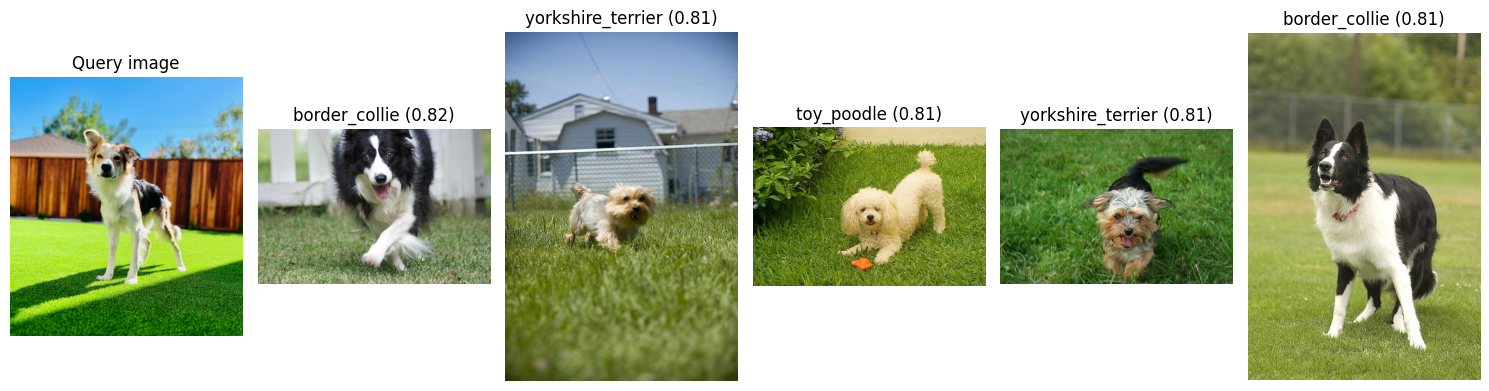

(autoscaler +12m47s) [autoscaler] [4xT4:48CPU-192GB] Attempting to add 1 node to the cluster (increasing from 0 to 1).
(autoscaler +12m52s) [autoscaler] [4xT4:48CPU-192GB|g4dn.12xlarge] [us-west-2a] [on-demand] Launched 1 instance.
(autoscaler +13m37s) [autoscaler] Cluster upscaled to {104 CPU, 8 GPU}.
(autoscaler +15m32s) [autoscaler] [8CPU-32GB] Attempting to add 1 node to the cluster (increasing from 0 to 1).
(autoscaler +15m32s) [autoscaler] [8CPU-32GB|m5.2xlarge] [us-west-2a] [on-demand] Launched 1 instance.
(autoscaler +16m2s) [autoscaler] [4xT4:48CPU-192GB] Attempting to add 1 node to the cluster (increasing from 1 to 2).
(autoscaler +16m2s) [autoscaler] [4xT4:48CPU-192GB|g4dn.12xlarge] [us-west-2a] [on-demand] Launched 1 instance.
(autoscaler +16m7s) [autoscaler] Cluster upscaled to {112 CPU, 8 GPU}.
(autoscaler +16m52s) [autoscaler] Cluster upscaled to {160 CPU, 12 GPU}.
(autoscaler +19m52s) [autoscaler] Downscaling node i-0e941ed71ef3480ee (node IP: 10.0.34.27) due to node id

(raylet, ip=10.0.4.102) Using CPython 3.12.11 interpreter at: /home/ray/anaconda3/bin/python3.12
(raylet, ip=10.0.4.102) Creating virtual environment at: .venv
(raylet, ip=10.0.4.102)    Building doggos @ file:///tmp/ray/session_2025-08-21_18-48-13_464408_2298/runtime_resources/working_dir_files/_ray_pkg_f79228c33bd2a431/doggos
(raylet, ip=10.0.4.102) Downloading pillow (6.3MiB)
(raylet, ip=10.0.4.102) Downloading grpcio (5.9MiB)
(raylet, ip=10.0.4.102) Downloading sqlalchemy (3.2MiB)
(raylet, ip=10.0.4.102) Downloading pydantic-core (1.9MiB)
(raylet, ip=10.0.4.102) Downloading jedi (1.5MiB)
(raylet, ip=10.0.4.102) Downloading virtualenv (5.7MiB)
(raylet, ip=10.0.4.102) Downloading pandas (11.4MiB)
(raylet, ip=10.0.4.102) Downloading setuptools (1.1MiB)
(raylet, ip=10.0.4.102) Downloading uvloop (4.5MiB)
(raylet, ip=10.0.4.102) Downloading nvidia-cuda-nvrtc-cu12 (22.6MiB)
(raylet, ip=10.0.4.102) Downloading sympy (6.0MiB)
(raylet, ip=10.0.4.102) Downloading numpy (15.9MiB)
(raylet, ip=

In [ ]:
# Top matches by embedding similarity.
embeddings_ds = ray.data.read_parquet(embeddings_path)
top_matches = get_top_matches(embedding, embeddings_ds, n=5)
display_top_matches(url, top_matches)


**🚨 Note**: Reset this notebook using the **"🔄 Restart"** button location at the notebook's menu bar. This way we can free up all the variables, utils, etc. used in this notebook.